In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold, ParameterGrid

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            nn.SELU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.regressor(x)
        return x

In [5]:
data_name = "all_3_species_oxides"
fig_folder = "plots_SELU/"

In [6]:
df1 = pd.read_pickle(f"data/all_3_species_oxides.pkl")
df2 = pd.read_pickle(f"data/all_sup4_species_oxides.pkl")
df = df1.append(df2)

In [7]:
df = drop_duplicates(df)
df

Number of molecules 10772


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b281fdee92d2d2b2,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOOs_pv/...,Ag1O3Os1,"[1, 3, 1]","[Ag, O, Os]",5,221,cP5,"[3.9184369, 3.9184369, 3.9184369, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.95922, 1.95922], [1....",-5.34058,0.427456
2,aflow:0783c5b47a9319f1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOP/T000...,Ag1O3P1,"[1, 3, 1]","[Ag, O, P]",5,221,cP5,"[3.57933, 3.57933, 3.57933, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [-0.0, 1.78966, 1.78966], [1...",-4.90593,-0.316921
4,aflow:701ef4b4f46ea7cd,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPb_d/T...,Ag1O3Pb1,"[1, 3, 1]","[Ag, O, Pb]",5,221,cP5,"[4.2942064, 4.2942064, 4.2942064, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.1471, 2.1471], [2.14...",-3.97006,0.295059
6,aflow:a7a77ee138e41496,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPd_pv/...,Ag1O3Pd1,"[1, 3, 1]","[Ag, O, Pd]",5,221,cP5,"[3.9991958, 3.9991958, 3.9991958, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.9996, 1.9996], [1.99...",-3.40735,1.19322
8,aflow:5fee8d04571dae6f,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPt/T00...,Ag1O3Pt1,"[1, 3, 1]","[Ag, O, Pt]",5,221,cP5,"[3.9809833, 3.9809833, 3.9809833, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.99049, 1.99049], [1....",-3.71702,1.01812
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7683,aflow:5644157e91938d95,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/ORC/O6P1P...,O72P12Pb12V12,"[72, 12, 12, 12]","[O, P, Pb, V]",108,62,oP108,"[9.977346, 11.1527, 13.95526, 90.0, 90.0, 90.0]","[[0.6797042, 0.45610845, 0.40999335], [0.82029...","[[6.78164, 5.08684, 5.72156], [8.18437, 10.663...",-7.11946,None
7684,aflow:8c81bc3abe9ebab2,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/HEX/O18P3...,O72P12Rb8Ti4V12,"[72, 12, 8, 4, 12]","[O, P, Rb, Ti, V]",108,184,hP108,"[13.79752, 13.79752, 9.64783, 90.0, 90.0, 120....","[[0.54729804, 0.32884722, 0.10882047], [0.6711...","[[6.04428, -2.61028, 1.04988], [6.1371, -5.409...",-7.28782,None
7685,aflow:71319e153afa0094,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/HEX/O12P3...,O72P18Yb2Zr12,"[72, 18, 2, 12]","[O, P, Yb, Zr]",104,165,hP104,"[8.987626, 8.991722, 22.77147, 89.99246, 90.0,...","[[0.97374023, 0.79807373, 0.19540543], [0.2022...","[[7.96576, -1.36524, 4.45014], [1.70081, -0.20...",-8.09016,None
7686,aflow:795cb1ecdf6421b5,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/MCLC/O8P2...,O8P2Rb1Ta1,"[8, 2, 1, 1]","[O, P, Rb, Ta]",12,12,mS24,"[5.106274, 5.106274, 8.534863, 87.23087, 87.23...","[[0.78163293, 0.30910869, 0.65842502], [0.6908...","[[1.2511, 5.07711, 5.61312], [1.2511, 4.13327,...",-7.62969,None


In [9]:
df = pd.read_pickle(f"data/{data_name}.pkl")
df = drop_duplicates(df)
df

Number of molecules 5456


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b281fdee92d2d2b2,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOOs_pv/...,Ag1O3Os1,"[1, 3, 1]","[Ag, O, Os]",5,221,cP5,"[3.9184369, 3.9184369, 3.9184369, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.95922, 1.95922], [1....",-5.34058,0.427456
2,aflow:0783c5b47a9319f1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOP/T000...,Ag1O3P1,"[1, 3, 1]","[Ag, O, P]",5,221,cP5,"[3.57933, 3.57933, 3.57933, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [-0.0, 1.78966, 1.78966], [1...",-4.90593,-0.316921
4,aflow:701ef4b4f46ea7cd,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPb_d/T...,Ag1O3Pb1,"[1, 3, 1]","[Ag, O, Pb]",5,221,cP5,"[4.2942064, 4.2942064, 4.2942064, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.1471, 2.1471], [2.14...",-3.97006,0.295059
6,aflow:a7a77ee138e41496,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPd_pv/...,Ag1O3Pd1,"[1, 3, 1]","[Ag, O, Pd]",5,221,cP5,"[3.9991958, 3.9991958, 3.9991958, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.9996, 1.9996], [1.99...",-3.40735,1.19322
8,aflow:5fee8d04571dae6f,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPt/T00...,Ag1O3Pt1,"[1, 3, 1]","[Ag, O, Pt]",5,221,cP5,"[3.9809833, 3.9809833, 3.9809833, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.99049, 1.99049], [1....",-3.71702,1.01812
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11883,aflow:aaf7c3d68a5e61eb,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4Tm1...,O8Tm2V2,"[8, 2, 2]","[O, Tm, V]",12,141,tI24,"[5.926409, 5.926409, 5.926409, 106.3931, 106.3...","[[0.67778748, 0.49098905, 0.81320157], [0.6777...","[[2.22395, 3.55034, 1.11949], [1.3264, 0.0, 4....",-8.21900,None
11884,aflow:dd0ff61000b8e748,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V1Y...,O8V2Y2,"[8, 2, 2]","[O, V, Y]",12,141,tI24,"[6.019827, 6.019827, 6.019827, 106.199, 106.19...","[[0.86631316, 0.80059798, 0.065715186], [0.234...","[[0.0, 0.47505, 5.09108], [3.61447, -0.47505, ...",-8.44561,None
11895,aflow:b9e0c6c998904bf1,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V1Y...,O8V2Yb2,"[8, 2, 2]","[O, V, Yb]",12,141,tI24,"[5.961606, 5.961606, 5.961606, 106.3982, 106.3...","[[0.32709444, 0.51588908, 0.18879464], [0.3270...","[[1.34845, -0.0, 2.0722], [2.22276, 3.57122, -...",-7.03838,None
11898,aflow:36a24bb71d323a35,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V2Z...,O8V4Zn2,"[8, 4, 2]","[O, V, Zn]",14,141,tI28,"[5.976299, 5.976299, 5.976299, 120.0156, 120.0...","[[0.25815325, 0.24220713, 0.98405389], [0.2581...","[[2.89217, 2.98745, -2.04451], [3.08272, 0.0, ...",-7.07798,None


In [8]:
elem_counts = pd.Series(np.hstack(np.array(df.species))).value_counts()
low_freq = elem_counts[elem_counts < 50].index.values
low_freq_mask = df.species.apply(lambda s: len(np.setdiff1d(s, low_freq)) < len(s))
df = df[(df.natoms <= 75) & ~low_freq_mask]
df

,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b281fdee92d2d2b2,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOOs_pv/...,Ag1O3Os1,"[1, 3, 1]","[Ag, O, Os]",5,221,cP5,"[3.9184369, 3.9184369, 3.9184369, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.95922, 1.95922], [1....",-5.34058,0.427456
2,aflow:0783c5b47a9319f1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOP/T000...,Ag1O3P1,"[1, 3, 1]","[Ag, O, P]",5,221,cP5,"[3.57933, 3.57933, 3.57933, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [-0.0, 1.78966, 1.78966], [1...",-4.90593,-0.316921
4,aflow:701ef4b4f46ea7cd,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPb_d/T...,Ag1O3Pb1,"[1, 3, 1]","[Ag, O, Pb]",5,221,cP5,"[4.2942064, 4.2942064, 4.2942064, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.1471, 2.1471], [2.14...",-3.97006,0.295059
6,aflow:a7a77ee138e41496,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPd_pv/...,Ag1O3Pd1,"[1, 3, 1]","[Ag, O, Pd]",5,221,cP5,"[3.9991958, 3.9991958, 3.9991958, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.9996, 1.9996], [1.99...",-3.40735,1.19322
8,aflow:5fee8d04571dae6f,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPt/T00...,Ag1O3Pt1,"[1, 3, 1]","[Ag, O, Pt]",5,221,cP5,"[3.9809833, 3.9809833, 3.9809833, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.99049, 1.99049], [1....",-3.71702,1.01812
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7678,aflow:4f8aaab657f9ae34,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/FCC/O6Sb1...,O6Sb1Sr2Y1,"[6, 1, 2, 1]","[O, Sb, Sr, Y]",10,225,cF40,"[5.938002, 5.938002, 5.938002, 60.0, 60.0, 60.0]","[[0.73723692, 0.26276308, 0.73723692], [0.2627...","[[4.1988, 6.19102, 4.1988], [4.1988, 2.20658, ...",-7.00231,-2.92663
7680,aflow:bfad83976a848205,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O6Sr2...,O6Sr2Ta1Y1,"[6, 2, 1, 1]","[O, Sr, Ta, Y]",10,87,tI20,"[5.931746, 5.931746, 5.931746, 120.8063, 120.8...","[[0.26277386, 0.26277386, -0.0], [0.73722614, ...","[[-0.0, -0.0, 2.23094], [-0.0, -0.0, 6.25902],...",-8.14799,None
7681,aflow:6043b05f66a2a98d,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/FCC/O6Sr2...,O6Sr2W1Zn1,"[6, 2, 1, 1]","[O, Sr, W, Zn]",10,225,cF40,"[5.644814, 5.644814, 5.644814, 60.0, 60.0, 60.0]","[[0.24299048, 0.75700952, 0.75700952], [0.7570...","[[6.04319, 3.99149, 3.99149], [1.93979, 3.9914...",-6.93351,None
7686,aflow:795cb1ecdf6421b5,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/MCLC/O8P2...,O8P2Rb1Ta1,"[8, 2, 1, 1]","[O, P, Rb, Ta]",12,12,mS24,"[5.106274, 5.106274, 8.534863, 87.23087, 87.23...","[[0.78163293, 0.30910869, 0.65842502], [0.6908...","[[1.2511, 5.07711, 5.61312], [1.2511, 4.13327,...",-7.62969,None


In [9]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(76,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir',
        'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni',
        'O', 'Os', 'P', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru',
        'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tb', 'Tc', 'Te',
        'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Yb', 'Zn', 'Zr'],
       dtype='<U2'))

In [10]:
net = VoxelNet(nchannel)
count_parameters(net)

79777

## Parameters

In [12]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
weigth_decay = 0.01

device = get_default_device()

In [13]:
ml = MolLoader(df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     reduce_data=True, device=device, mode='cartesian')

Initialised MolLoader with 10276 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True


In [18]:
ml.reciprocal_data[-1][0][2][0].astype(np.float16)

array([[-13.59  , -13.59  , -12.914 , ...,  12.914 ,  13.59  ,  13.59  ],
       [ -5.12  ,  -5.12  ,  -6.24  , ...,   6.24  ,   5.12  ,   5.12  ],
       [ -0.1711,   1.3   ,  -2.32  , ...,   2.32  ,  -1.3   ,   0.1711]],
      dtype=float16)

##  Cartesian

(4635, 13) (515, 13)
Initialised MolLoader with 4635 compounds.
    sigma=0.1, L=10, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True
Initialised MolLoader with 515 compounds.
    sigma=0.1, L=10, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=False, rotate=False, reflect=False
Epoch 0: train loss 5.404980659484863 val loss 1.9697494506835938
Epoch 1: train loss 1.408375859260559 val loss 0.7636477947235107
Epoch 2: train loss 0.5246871709823608 val loss 0.5628257989883423
Epoch 3: train loss 0.4717341959476471 val loss 0.5025781989097595
Epoch 4: train loss 0.4672766327857971 val loss 0.45012491941452026
Epoch 5: train loss 0.4620007574558258 val loss 0.45717403292655945
Epoch 6: train loss 0.46692582964897156 val loss 0.47377341985702515
Epoch 7: train loss 0.4382983446121216 val loss 0.41898873448371887
Epoch 8: train loss 0.4366348087787628 val loss 0.4575745463371277
Epoch 9: train loss 0.39451098442077637 val loss 0.4305911064

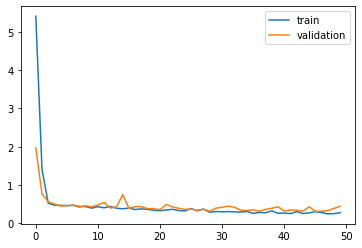

In [11]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     reduce_data=True, device=device, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=False, reflect_randomly=False,
                    device=device, reduce_data=True, mode='cartesian')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weigth_decay)

### Train Plots

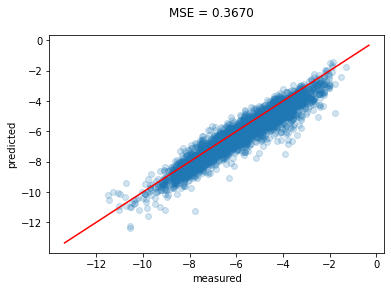

In [12]:
# 0.2605 50 epoch, L = 10, wd=0.01
# 0.3670 50 epoch, L = 10, wd=0.01 drop_low_freq
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

Mean Variance:  0.009207986


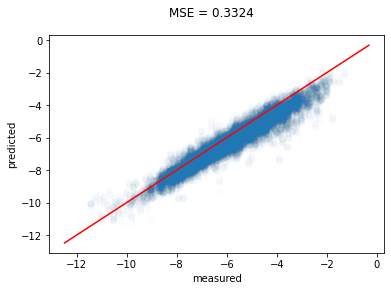

In [13]:
# 0.2301 50 epoch, L = 10, wd=0.01
# 0.3324 50 epoch, L = 10, wd=0.01 drop_low_freq
# transformations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats, alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_train.pdf")

### Test Plots

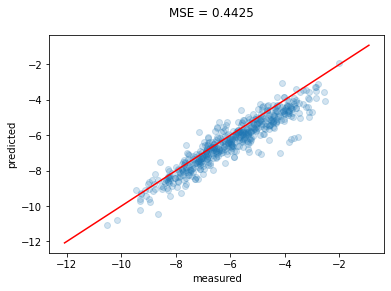

In [14]:
# 0.2970 50 epoch, L = 10, wd=0.01
# 0.4425 50 epoch, L = 10, wd=0.01 drop_low_freq
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

Mean Variance:  0.00929564


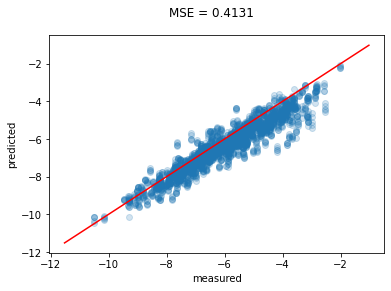

In [15]:
# 0.2779 50 epoch, L = 10, wd=0.01
# 0.4131 50 epoch, L = 10, wd=0.01 drop_low_freq
# transformations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_cartesian_test.pdf")

In [16]:
smaller_df = pd.read_pickle(f"data/all_221_cp5_3_species_oxides.pkl")
smaller_df = drop_duplicates(smaller_df)

Number of molecules 1983


In [17]:
smaller_df_train = smaller_df[smaller_df.compound.isin(train_df.compound)]
smaller_df_test = smaller_df[smaller_df.compound.isin(test_df.compound)]

Initialised MolLoader with 1756 compounds.
    sigma=0.1, L=10, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True
Mean Variance:  0.009485538


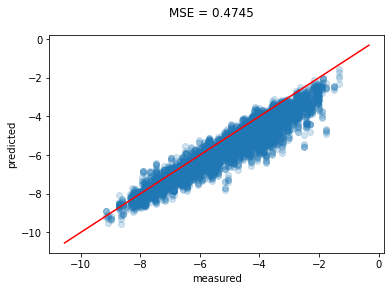

In [18]:
ml_pred = MolLoader(smaller_df_train, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, reduce_data=True, mode='cartesian')
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
plt.show()

Initialised MolLoader with 182 compounds.
    sigma=0.1, L=10, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True
Mean Variance:  0.009253443


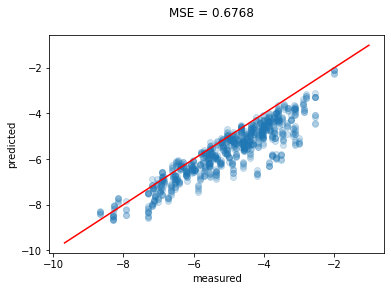

In [19]:
ml_pred = MolLoader(smaller_df_test, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, reduce_data=True, mode='cartesian')
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
plt.show()

## Spherical

In [ ]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     reduce_data=True, device=device, mode='spherical')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=False, reflect_randomly=False,
                    device=device, reduce_data=True, mode='spherical')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weigth_decay)

(4635, 13) (515, 13)
Initialised MolLoader with 4635 compounds.
    sigma=0.1, L=10, N=32, nchannel=72, mode=spherical, device=cuda
    shuffle=True, rotate=True, reflect=True
Initialised MolLoader with 515 compounds.
    sigma=0.1, L=10, N=32, nchannel=72, mode=spherical, device=cuda
    shuffle=False, rotate=False, reflect=False
Epoch 0: train loss 5.222064018249512 val loss 1.4766371250152588
Epoch 1: train loss 0.8499882221221924 val loss 0.4943494200706482
Epoch 2: train loss 0.5420499444007874 val loss 0.4648342728614807
Epoch 3: train loss 0.5226144194602966 val loss 0.6202806234359741
Epoch 4: train loss 0.4993671774864197 val loss 0.8139448165893555
Epoch 5: train loss 0.4938507080078125 val loss 0.4180399775505066
Epoch 6: train loss 0.4574050307273865 val loss 0.4031054973602295
Epoch 7: train loss 0.43619900941848755 val loss 0.4297284483909607
Epoch 8: train loss 0.4532923996448517 val loss 0.5021295547485352
Epoch 9: train loss 0.4083721935749054 val loss 0.41870945692062

### Train Plots

In [ ]:
# 0.0596 50 epoch, L = 12.8, wd=0.00 ??
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

In [ ]:
# 0.0538 50 epoch, L = 12.8, wd=0.00 ??
# transformations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats, alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_train.pdf")

### Test Plots

In [ ]:
# 0.2501 50 epoch, L = 12.8, wd=0.00 ??
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

In [ ]:
# 0.2526 50 epoch, L = 12.8, wd=0.00 ??
# transformations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_spherical_test.pdf")

## Cross Validation

### Cartesian

In [ ]:
seed_everything()
all_ys = []
all_y_hats = []
all_vars = []

all_train_ys = []
all_train_y_hats = []
all_train_vars = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     reduce_data=True, device=device, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=False, reflect_randomly=False,
                    device=device, reduce_data=True, mode='cartesian')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_train_ys.append(ys)
    all_train_y_hats.append(y_hats)
    all_train_vars.append(np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_ys.append(ys)
    all_y_hats.append(y_hats)
    all_vars.append(np.mean(np.var(y_hats.reshape(5,-1), axis=0)))

In [ ]:
# 0.0474 50 epoch
plot_predictions(np.hstack(all_train_ys), np.hstack(all_train_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_cv_train.pdf")
print("Avg Mean Variance:",  np.mean(all_vars))

In [ ]:
# 0.2758 50 epoch
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_cv_test.pdf")
print("Avg Mean Variance:",  np.mean(all_train_vars))

### Spherical

In [ ]:
seed_everything()
all_ys = []
all_y_hats = []
all_vars = []

all_train_ys = []
all_train_y_hats = []
all_train_vars = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     reduce_data=True, device=device, mode='spherical')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=False, reflect_randomly=False,
                    device=device, reduce_data=True, mode='spherical')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_train_ys.append(ys)
    all_train_y_hats.append(y_hats)
    all_train_vars.append(np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_ys.append(ys)
    all_y_hats.append(y_hats)
    all_vars.append(np.mean(np.var(y_hats.reshape(5,-1), axis=0)))

In [ ]:
# 0.0502 50 epoch
plot_predictions(np.hstack(all_train_ys), np.hstack(all_train_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_cv_train.pdf")
print("Avg Mean Variance:",  np.mean(all_vars))

In [ ]:
# 0.2707 50 epoch
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_cv_test.pdf")
print("Avg Mean Variance:",  np.mean(all_train_vars))

## Parameter Grid Search

In [ ]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

In [ ]:
param_grid = ParameterGrid({
    "sigma": [0.01, 0.1, 0.5, 1.],
    "L": [10, 12.8, 15],
    "weight_decay": [0., 0.001, 0.01]
})

In [ ]:
len(list(param_grid))

In [ ]:
device = get_default_device()

results = []

for i, params in enumerate(param_grid):
    L = params["L"]
    sigma = params["sigma"]
    weight_decay = params["weight_decay"]
    print(f"{i}. L = {L}, sigma = {sigma}, weight_decay = {weight_decay}")

    seed_everything()
    
    net = VoxelNet(nchannel)
    net = net.to(device)

    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     reduce_data=True, device=device, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=False, reflect_randomly=False,
                    device=device, reduce_data=True, mode='cartesian')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, verbose=False)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys_train, y_hats_train = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys_train, y_hats_train)
    plt.show()
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    
    results.append({"train": np.mean((ys_train - y_hats_train)**2), "test": np.mean((ys - y_hats)**2)})

In [ ]:
for param, mse in zip(param_grid, results):
    print(param, mse)